# Anime Recommendation By Honglin Zhu And Ruijie Shi

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

Data for rating from users towards anime

In [41]:
rating = pd.read_csv("rating.csv")
rating = rating.loc[rating["user_id"] <= 12000 ]
anime = pd.read_csv("anime.csv")
rating.head()

user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1

Data for anime information

In [42]:
anime.head()

anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266

According to the information of anime data, we drop the anime without genre(s).

In [43]:
anime.info()

anime = anime.dropna(subset = ["genre"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


Only keep the data with anime_id and genre.

In [44]:
anime1 = anime[["anime_id","genre"]]
anime1.head()

anime_id                                              genre
0     32281               Drama, Romance, School, Supernatural
1      5114  Action, Adventure, Drama, Fantasy, Magic, Mili...
2     28977  Action, Comedy, Historical, Parody, Samurai, S...
3      9253                                   Sci-Fi, Thriller
4      9969  Action, Comedy, Historical, Parody, Samurai, S...

Process the data, get that, for each anime, if it belongs to a genre, set the value as 1, otherwise as None.

In [45]:
for index in anime1.index:
    genre_list = anime1.loc[index]["genre"].split(", ")
    for genre in genre_list:
        anime1.loc[index,genre] = 1
anime1.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


anime_id                                              genre  Drama  \
0     32281               Drama, Romance, School, Supernatural    1.0   
1      5114  Action, Adventure, Drama, Fantasy, Magic, Mili...    1.0   
2     28977  Action, Comedy, Historical, Parody, Samurai, S...    NaN   
3      9253                                   Sci-Fi, Thriller    NaN   
4      9969  Action, Comedy, Historical, Parody, Samurai, S...    NaN   

   Romance  School  Supernatural  Action  Adventure  Fantasy  Magic  ...  \
0      1.0     1.0           1.0     NaN        NaN      NaN    NaN  ...   
1      NaN     NaN           NaN     1.0        1.0      1.0    1.0  ...   
2      NaN     NaN           NaN     1.0        NaN      NaN    NaN  ...   
3      NaN     NaN           NaN     NaN        NaN      NaN    NaN  ...   
4      NaN     NaN           NaN     1.0        NaN      NaN    NaN  ...   

   Shounen Ai  Game  Dementia  Harem  Cars  Kids  Shoujo Ai  Hentai  Yaoi  \
0         NaN   NaN       NaN    NaN   NaN   NaN        NaN     NaN   NaN   
1         NaN   NaN       NaN    NaN   NaN   NaN        NaN     NaN   NaN   
2         NaN   NaN       NaN    NaN   NaN   NaN        NaN     NaN   NaN   
3         NaN   NaN       NaN    NaN   NaN   NaN        NaN     NaN   NaN   
4         NaN   NaN       NaN    NaN   NaN   NaN        NaN     NaN   NaN   

   Yuri  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN  

[5 rows x 45 columns]

Merge the data for anime with genre value with the corresponding rating from each user.

In [46]:
user_anime = rating.merge(anime1,on='anime_id')
user_anime.head(1)

user_id  anime_id  rating  \
0        1        20      -1   

                                               genre  Drama  Romance  School  \
0  Action, Comedy, Martial Arts, Shounen, Super P...    NaN      NaN     NaN   

   Supernatural  Action  Adventure  ...  Shounen Ai  Game  Dementia  Harem  \
0           NaN     1.0        NaN  ...         NaN   NaN       NaN    NaN   

   Cars  Kids  Shoujo Ai  Hentai  Yaoi  Yuri  
0   NaN   NaN        NaN     NaN   NaN   NaN  

[1 rows x 47 columns]

Rating -1 means that the user has watched the anime but has not rated it. Hence we set the value as 5, which is the medium from 0 to 10.

In [47]:
user_anime.loc[user_anime['rating'] == -1, 'rating'] = 5
#user_anime.drop('genre',axis=1, inplace=True)
user_anime.head(1)

user_id  anime_id  rating  \
0        1        20       5   

                                               genre  Drama  Romance  School  \
0  Action, Comedy, Martial Arts, Shounen, Super P...    NaN      NaN     NaN   

   Supernatural  Action  Adventure  ...  Shounen Ai  Game  Dementia  Harem  \
0           NaN     1.0        NaN  ...         NaN   NaN       NaN    NaN   

   Cars  Kids  Shoujo Ai  Hentai  Yaoi  Yuri  
0   NaN   NaN        NaN     NaN   NaN   NaN  

[1 rows x 47 columns]

According to the rating from a user towards an anime, get the rating from that user towards the corresponding genres.

In [48]:
genre = anime1.columns.tolist()
genre.remove("anime_id")
genre.remove("genre")

user_anime0 = user_anime.copy(deep=True)
user_anime0[genre] = user_anime0[genre].mul(user_anime0['rating'], axis=0)
user_anime0.head(1)

user_id  anime_id  rating  \
0        1        20       5   

                                               genre  Drama  Romance  School  \
0  Action, Comedy, Martial Arts, Shounen, Super P...    NaN      NaN     NaN   

   Supernatural  Action  Adventure  ...  Shounen Ai  Game  Dementia  Harem  \
0           NaN     5.0        NaN  ...         NaN   NaN       NaN    NaN   

   Cars  Kids  Shoujo Ai  Hentai  Yaoi  Yuri  
0   NaN   NaN        NaN     NaN   NaN   NaN  

[1 rows x 47 columns]

Group by the genre rating information by each user and each anime respectively, with the mean value in each group. We only demonstrate the data grouped by each user.

In [49]:
user_anime0.drop(columns=["rating","genre"],inplace = True)
anime_genre_rating = (user_anime0.groupby(by='anime_id').mean())
anime_genre_rating.drop(columns=["user_id"],inplace = True)
user_anime0.drop(columns=["anime_id"],inplace = True)
user_genre_rating = (user_anime0.groupby(by='user_id').mean())
user_genre_rating.head()
#anime_genre_rating.head()

Drama   Romance    School  Supernatural    Action  Adventure  \
user_id                                                                    
1        5.000000  5.180723  5.138889      5.084746  5.200000   5.333333   
2             NaN       NaN  7.500000           NaN       NaN        NaN   
3        7.451613  7.555556  8.500000      7.384615  7.218750   7.479167   
4        5.000000  5.000000  5.000000      5.000000  5.000000   5.000000   
5        5.217949  3.019231  3.506757      4.360000  4.707006   5.182796   

          Fantasy     Magic  Military    Shounen  ...  Shounen Ai      Game  \
user_id                                           ...                         
1        5.108696  5.000000      5.00   5.000000  ...         NaN  5.833333   
2             NaN       NaN       NaN  10.000000  ...         NaN       NaN   
3        7.576923  8.153846      8.00   7.928571  ...         NaN  7.000000   
4        5.000000  5.000000      5.00   5.000000  ...         NaN  5.000000   
5        4.416667  4.058824      4.75   4.798780  ...         NaN  4.100000   

         Dementia     Harem  Cars      Kids  Shoujo Ai  Hentai  Yaoi  Yuri  
user_id                                                                     
1             NaN  5.147059   NaN       NaN        5.0     NaN   NaN   NaN  
2             NaN       NaN   NaN       NaN        NaN     NaN   NaN   NaN  
3             NaN       NaN   NaN  7.052632        NaN     NaN   NaN   NaN  
4             NaN  5.000000   NaN       NaN        NaN     NaN   NaN   NaN  
5             1.0  2.217949   6.0  5.555556        1.0     NaN   NaN   NaN  

[5 rows x 43 columns]

Only fill the None values as 0 for the data grouped by each user, for the anime one we do not do so for the sake of later processing. We  demonstrate the data grouped by each anime here.

In [50]:
user_genre_rating.fillna(value=0,inplace=True)
#anime_genre_rating.fillna(value=0,inplace=True)
#user_genre_rating.head()
anime_genre_rating.head()

Drama  Romance  School  Supernatural    Action  Adventure  \
anime_id                                                                 
1         8.353458      NaN     NaN           NaN  8.353458   8.353458   
5         7.894290      NaN     NaN           NaN  7.894290        NaN   
6              NaN      NaN     NaN           NaN  7.870016        NaN   
7         7.187251      NaN     NaN      7.187251  7.187251        NaN   
8              NaN      NaN     NaN      6.694118       NaN   6.694118   

           Fantasy     Magic  Military   Shounen  ...  Shounen Ai  Game  \
anime_id                                          ...                     
1              NaN       NaN       NaN       NaN  ...         NaN   NaN   
5              NaN       NaN       NaN       NaN  ...         NaN   NaN   
6              NaN       NaN       NaN       NaN  ...         NaN   NaN   
7              NaN  7.187251       NaN       NaN  ...         NaN   NaN   
8         6.694118       NaN       NaN  6.694118  ...         NaN   NaN   

          Dementia  Harem  Cars  Kids  Shoujo Ai  Hentai  Yaoi  Yuri  
anime_id                                                              
1              NaN    NaN   NaN   NaN        NaN     NaN   NaN   NaN  
5              NaN    NaN   NaN   NaN        NaN     NaN   NaN   NaN  
6              NaN    NaN   NaN   NaN        NaN     NaN   NaN   NaN  
7              NaN    NaN   NaN   NaN        NaN     NaN   NaN   NaN  
8              NaN    NaN   NaN   NaN        NaN     NaN   NaN   NaN  

[5 rows x 43 columns]

We split our data which is genre rating for each user as follows, 6000 for cluster training, 2000 for similar user training, 2000 for validation and 2000 for test.

In [51]:
from sklearn.model_selection import train_test_split
user_genre_rating_train0, user_genre_rating_test0 = train_test_split(user_genre_rating, test_size = 1/3,shuffle=False)
user_genre_rating_train1, user_genre_rating_train2 = train_test_split(user_genre_rating_train0,test_size = 0.25, shuffle = False)
user_genre_rating_validation,user_genre_rating_test = train_test_split(user_genre_rating_test0,test_size = 0.5, shuffle = False)
print(user_genre_rating_train1.shape)
print(user_genre_rating_train2.shape)
print(user_genre_rating_validation.shape)
print(user_genre_rating_test.shape)

(6000, 43)
(2000, 43)
(2000, 43)
(2000, 43)


We apply our first train set for K Means clustering at first. We demonstrate the PCA outcome, in order to find a proper PCA value to determine the range for the later K Means training.

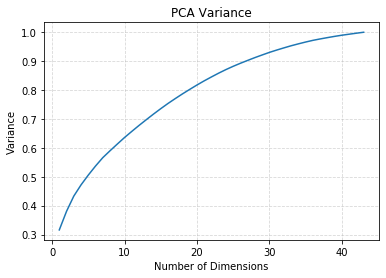

In [54]:
%matplotlib inline

pca = PCA()
pca.fit(user_genre_rating_train1)
variance = np.cumsum(pca.explained_variance_ratio_) 

plt.plot(range(1, len(variance)+1), variance)
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("PCA Variance")
plt.xlabel("Number of Dimensions")
_ = plt.ylabel("Variance")

From the picture, we choose 20 as our PCA parameter and transform our 6000 cluster training data as user_pca_train1.

In [55]:
pca = PCA()
n_dimensions = 20
pca.set_params(n_components = n_dimensions)
pca.fit(user_genre_rating_train1)

user_pca_train1 = pd.DataFrame(pca.transform(user_genre_rating_train1))
user_pca_train2 = pd.DataFrame(pca.transform(user_genre_rating_train2))
user_pca_validation = pd.DataFrame(pca.transform(user_genre_rating_validation))
user_pca_test = pd.DataFrame(pca.transform(user_genre_rating_test))

user_pca_train1['user_id'] = user_genre_rating_train1.index
user_pca_train1.set_index('user_id',inplace=True)
user_pca_train1.head()

0          1         2         3         4         5   \
user_id                                                                 
1         7.897883  -2.026197  2.926859 -4.317982  1.798559 -4.237930   
2        25.860290  -8.534135  2.338711  1.322816 -2.838099 -2.983207   
3        -5.174689   3.188440 -2.295545 -0.511890 -7.168313 -3.056720   
4         7.313143  -0.567813 -0.603114 -0.756351 -4.041689 -3.153429   
5         5.213700 -11.095255 -1.073975  0.452048 -4.929597 -1.388747   

               6         7         8         9         10        11        12  \
user_id                                                                         
1       -1.211609 -3.178125  1.689133 -1.121212  1.813612  3.302872 -2.403009   
2        3.685779 -5.667445 -5.451364  3.205008  0.296297  2.285099 -0.494187   
3        0.465938 -0.219931 -3.280515  3.549334  1.302386 -1.306504 -5.002796   
4       -3.525685 -3.952161  0.043406  1.866641 -0.104860  0.294330 -0.564357   
5        1.109588 -1.842904  0.414873 -2.322207 -2.250323 -3.011274 -1.745247   

               13        14        15        16        17        18        19  
user_id                                                                        
1       -2.280566  3.246929 -0.715944 -0.976728  0.495191  2.239640  0.132681  
2       -0.239521  1.444350  0.044965 -0.661972  0.161057 -1.009006  0.382819  
3        2.097175  0.392967  0.619502  2.411122  0.676202  0.681738  0.391608  
4        1.202532 -2.165342  0.191696  1.341733  2.297641  2.064430  0.758375  
5        2.030152  3.146253 -0.533338 -0.964990 -2.572720 -0.862811  1.255008

In this way, according to the output inertia picture, we find that we should determine the K for K Means from 4 to 14.

In [56]:
cluster = range(2,15+1)
inertia = []
#score = []

for n in cluster:
    kmeans = KMeans(n_clusters=n, n_jobs=-1)
    kmeans.fit(user_pca_train1)
    inertia.append(kmeans.inertia_)
    #score.append(silhouette_score(user_pca, kmeans.labels_))

plt.plot(cluster,inertia,"bx-")
plt.xticks(cluster)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Inertia")
plt.show()

#plt.plot(cluster,score,"bx-")
#plt.xticks(cluster)
#plt.xlabel("Number of Clusters")
#plt.ylabel("Silhouette Score")
#plt.title("Silhouette")
#plt.show()

Reset the PCA parameter as 3, from which we can ensure the applicability of our K Means for clustering and KNN for finding similar users. And transform all the data including train, validation and test. After that, we choose a specific K for K Means in order to get an overview of the project in advance, and we will optimize the model later.

In [60]:
#project the users feature vector in 3 dimensions
pca = PCA()
pca.set_params(n_components = 3)
pca.fit(user_genre_rating_train1)

user_3d_train1 = pd.DataFrame(pca.transform(user_genre_rating_train1))
user_3d_train2 = pd.DataFrame(pca.transform(user_genre_rating_train2))
user_3d_validation = pd.DataFrame(pca.transform(user_genre_rating_validation))
user_3d_test = pd.DataFrame(pca.transform(user_genre_rating_test))

user_3d_train1['user_id'] = user_genre_rating_train1.index
user_3d_train1.set_index('user_id',inplace = True)

user_3d_train2['user_id'] = user_genre_rating_train2.index
user_3d_train2.set_index('user_id',inplace = True)

user_3d_validation['user_id'] = user_genre_rating_validation.index
user_3d_validation.set_index('user_id',inplace = True)

user_3d_test['user_id'] = user_genre_rating_test.index
user_3d_test.set_index('user_id',inplace = True)


kmeans = KMeans(n_clusters=8, n_init=30, n_jobs=-1)
user_3d_train1['label'] = kmeans.fit_predict(user_3d_train1)
user_3d_train1.head()

0          1         2  label
user_id                                       
1         7.897883  -2.026327  2.927302      4
2        25.860290  -8.534366  2.339784      2
3        -5.174689   3.188420 -2.295045      6
4         7.313143  -0.567869 -0.602519      7
5         5.213700 -11.094972 -1.075992      0

Here is the 3D visualization for the user clustering data.

In [61]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(user_3d_train1[0], user_3d_train1[1], user_3d_train1[2], c=user_3d_train1['label'].to_numpy(), cmap='viridis', s=10)
plt.title('Clusters')
plt.show()

The number of users in each cluster has been demonstrated.

In [62]:
print('Cluster Label\tNumber of Users in Cluster')
for idx, val in (pd.get_dummies(user_3d_train1['label'])).sum().iteritems():
    print(str(idx)+'\t\t'+str(val))

Cluster Label	Number of Users in Cluster
0		650
1		1305
2		610
3		845
4		574
5		695
6		788
7		533


With the clusters trained by 6000 first training users, we apply our 2000 train2 training users to trian the KNN model for similar users. Here we choose a specific K for KNN in order to get an overview of the project in advance, and we will optimize the model later. 

In [63]:
model = KNeighborsClassifier(n_neighbors=5,p=2)
model = model.fit(user_3d_train1[[0,1,2]],user_3d_train1["label"])

With the trained KNN model, we transform all our data for train, validation and test.

In [64]:
label1 = pd.DataFrame(model.predict(user_3d_train1[[0,1,2]]))
label2 = pd.DataFrame(model.predict(user_3d_train2[[0,1,2]]))
label3 = pd.DataFrame(model.predict(user_3d_validation[[0,1,2]]))
label4 = pd.DataFrame(model.predict(user_3d_test[[0,1,2]]))
label1.index = user_3d_train1.index
label2.index = user_3d_train2.index
label3.index = user_3d_validation.index
label4.index = user_3d_test.index

Here we show the users with labels from K Means, and his/her rating towards each anime. Again, we replace the -1 rating with 5.

In [65]:
user_rating_cluster = rating.join(user_3d_train1[['label']], on='user_id')
user_rating_cluster.loc[user_rating_cluster['rating'] == -1, 'rating'] = 5
user_rating_cluster.dropna(axis=0,inplace=True)
user_rating_cluster.head()

user_id  anime_id  rating  label
0        1        20       5    4.0
1        1        24       5    4.0
2        1        79       5    4.0
3        1       226       5    4.0
4        1       241       5    4.0

By counting the mean and count for each anime in every cluster, we define a metric to evaluate how popular the anime is.

In [66]:
clusters = (user_rating_cluster[['anime_id', 'rating', 'label']].groupby(by=['label', 'anime_id']).rating.agg(['mean', 'count']))
clusters["evaluation"] = clusters['mean'] * clusters['count']
clusters.head()

mean  count  evaluation
label anime_id                             
0.0   1         6.632743    226      1499.0
      5         6.104762    105       641.0
      6         5.973510    151       902.0
      7         5.757576     33       190.0
      8         5.500000      6        33.0

In [67]:
clusters_evaluation = clusters[['evaluation']].dropna()
clusters_evaluation.head()

evaluation
label anime_id            
0.0   1             1499.0
      5              641.0
      6              902.0
      7              190.0
      8               33.0

Here we get the top10 anime (ordered descending) in each cluster with their ids.

In [69]:
cluster_label = clusters_evaluation.index.get_level_values(0).unique().tolist()
rec = []
for c in cluster_label:
    rec.append(clusters_evaluation.loc[c].sort_values(by='evaluation', ascending=False).reset_index())
rec = pd.concat(rec, axis=1)
rec_10 = pd.DataFrame(rec.head(10))[["anime_id"]]
l = []
t = 0
for i in rec_10.columns:
    l.append(t)
    t += 1
rec_10.columns = l
rec_10.head()

0      1        2        3        4        5        6        7
0   1535.0   1535  11757.0  11757.0  11757.0   1535.0   1535.0   1535.0
1  16498.0   1575  16498.0  16498.0  16498.0  16498.0   1575.0  16498.0
2  11757.0  16498     20.0   1535.0    853.0  11757.0  16498.0   5114.0
3   1575.0   2904   6547.0   6547.0   6547.0  10620.0   2904.0     20.0
4   6547.0   5114   1535.0  10620.0   4224.0   6547.0   5114.0   1575.0

Define the function cluster_to_value. With the rating towards each genre for each anime, which is from anime_genre_rating, we get the average rating towards each genre in the cluster. The output will be a victor, each dimension is the rating towards each genre.

In [70]:
def cluster_to_value(s,anime_genre_rating):
    lv = []
    for an in s:
        a = anime_genre_rating.loc[anime_genre_rating.index == int(an)].copy(deep=True)
        lv.append(a.loc[a.index[0]])
    p = pd.DataFrame(lv)
    lm = []
    for col1 in p.columns:
        lm.append(p[col1].mean())
    arraym = np.array(lm)
    arraym[np.isnan(arraym)] = 0    
    return arraym

Here we define our error function with distance. X denotes our input user with his/her ratings towards each genre, the output will be the victor of the value computed by cluster_to_value() from the cluster located in. In other words, if the error is relatively small, it means that the recommended anime fits the preference of the user. We compute the error in two ways, with victor with full dimensions (according to each genre) and the reduced dimensions (according to the 3D output after PCA).

In [71]:
def error(X,Y):
    return (X-Y).dot((X-Y)) / (X.dot(X)*Y.dot(Y))

In this model with specific Ks for K Means and KNN, we compute the error for training set and validation set.

In [72]:
err = 0
err_3d = 0
dict_cl = dict()
for u in user_genre_rating_train2.index:
    arrayx = np.array(user_genre_rating_train2.loc[u])
    cl = int(label2.loc[u])
    
    if cl in dict_cl:
        arrayy = dict_cl[cl]
    else:
        arrayy = cluster_to_value(rec_10[cl],anime_genre_rating)
        dict_cl[cl] = arrayy
    
    err += error(arrayx,arrayy)
    
    arrayx_3d = np.array(user_3d_train2.loc[u])
    arrayy_3d = np.array(pca.transform([arrayy])[0])
    err_3d += error(arrayx_3d,arrayy_3d)
print(err,err_3d)

err = 0
err_3d = 0
dict_cl = dict()
for u in user_genre_rating_validation.index:
    arrayx = np.array(user_genre_rating_validation.loc[u])
    cl = int(label3.loc[u])

    if cl in dict_cl:
        arrayy = dict_cl[cl]
    else:
        arrayy = cluster_to_value(rec_10[cl],anime_genre_rating)
        dict_cl[cl] = arrayy
    err += error(arrayx,arrayy)
    
    arrayx_3d = np.array(user_3d_validation.loc[u])
    arrayy_3d = np.array(pca.transform([arrayy])[0])
    err_3d += error(arrayx_3d,arrayy_3d)
print(err,err_3d)


1.110027981308678 49.95882125062368
1.1357049973687858 33.716220889800475


According to the validation set, show the output information of each cluster with 10 recommended anime.

In [74]:
rec_10.head(10)

0      1        2        3        4        5        6        7
0   1535.0   1535  11757.0  11757.0  11757.0   1535.0   1535.0   1535.0
1  16498.0   1575  16498.0  16498.0  16498.0  16498.0   1575.0  16498.0
2  11757.0  16498     20.0   1535.0    853.0  11757.0  16498.0   5114.0
3   1575.0   2904   6547.0   6547.0   6547.0  10620.0   2904.0     20.0
4   6547.0   5114   1535.0  10620.0   4224.0   6547.0   5114.0   1575.0
5    121.0  11757   3457.0   4224.0   7054.0   5114.0    226.0  11757.0
6   4224.0   6547    853.0  19815.0   2167.0   1575.0    121.0    121.0
7    199.0   4224  18507.0   9919.0  18507.0    226.0   9253.0   2904.0
8   5114.0    226    120.0   8074.0   9919.0     20.0  11757.0    226.0
9   2904.0   9253    269.0   2167.0   4181.0   2904.0     30.0    813.0

Given two ranges for K in K Means and K in K NN to find the best Ks for our model among these ranges. Calculate the error for trianing set and validation set.

In [75]:
err1 = []
err1_v = []
for k1 in range(4,14+1):
    err2 = []
    err2_v = []
    for k2 in range(5,10+1):
        kmeans = KMeans(n_clusters=k1, n_init=30, n_jobs=-1)
        user_3d_train1['label'] = kmeans.fit_predict(user_3d_train1)
        model = KNeighborsClassifier(n_neighbors=k2,p=2)
        model = model.fit(user_3d_train1[[0,1,2]],user_3d_train1["label"])
        label1 = pd.DataFrame(model.predict(user_3d_train1[[0,1,2]]))
        label2 = pd.DataFrame(model.predict(user_3d_train2[[0,1,2]]))
        label3 = pd.DataFrame(model.predict(user_3d_validation[[0,1,2]]))
        label1.index = user_3d_train1.index
        label2.index = user_3d_train2.index
        label3.index = user_3d_validation.index
        
        user_rating_cluster = rating.join(user_3d_train1[['label']], on='user_id')
        user_rating_cluster.loc[user_rating_cluster['rating'] == -1, 'rating'] = 5
        user_rating_cluster.dropna(axis=0,inplace=True)
        clusters = (user_rating_cluster[['anime_id', 'rating', 'label']].groupby(by=['label', 'anime_id']).rating.agg(['mean', 'count']))
        clusters["evaluation"] = clusters['mean'] * clusters['count']
        clusters_evaluation = clusters[['evaluation']].dropna()
        
        cluster_label = clusters_evaluation.index.get_level_values(0).unique().tolist()
        rec = []
        for c in cluster_label:
            rec.append(clusters_evaluation.loc[c].sort_values(by='evaluation', ascending=False).reset_index())
        rec = pd.concat(rec, axis=1)
        rec_10 = pd.DataFrame(rec.head(10))[["anime_id"]]
        l = []
        t = 0
        for i in rec_10.columns:
            l.append(t)
            t += 1
        rec_10.columns = l

        err = 0
        err_3d = 0
        dict_cl = dict()
        for u in user_genre_rating_train2.index:
            arrayx = np.array(user_genre_rating_train2.loc[u])
            cl = int(label2.loc[u])

            if cl in dict_cl:
                arrayy = dict_cl[cl]
            else:
                arrayy = cluster_to_value(rec_10[cl],anime_genre_rating)
                dict_cl[cl] = arrayy

            err += error(arrayx,arrayy)

            arrayx_3d = np.array(user_3d_train2.loc[u])
            arrayy_3d = np.array(pca.transform([arrayy])[0])
            err_3d += error(arrayx_3d,arrayy_3d)

        err_v = 0
        err_3d_v = 0
        for u in user_genre_rating_validation.index:
            arrayx = np.array(user_genre_rating_validation.loc[u])
            cl = int(label3.loc[u])

            if cl in dict_cl:
                arrayy = dict_cl[cl]
            else:
                arrayy = cluster_to_value(rec_10[cl],anime_genre_rating)
                dict_cl[cl] = arrayy
            err_v += error(arrayx,arrayy)

            arrayx_3d = np.array(user_3d_validation.loc[u])
            arrayy_3d = np.array(pca.transform([arrayy])[0])
            err_3d_v += error(arrayx_3d,arrayy_3d)
        
        err2.append([k2,[err,err_3d]])
        err2_v.append([k2,[err_v,err_3d_v]])
    err1.append([k1,err2])
    err1_v.append([k1,err2_v])
    
print(err1)
print(err1_v)

[[4, [[5, [1.0981121555211086, 50.40778657769382]], [6, [1.0886771950730163, 50.94903832112893]], [7, [1.0887899831021237, 50.9456508297206]], [8, [1.1005056463360794, 50.6924613145916]], [9, [1.0961206068823215, 50.47964271743229]], [10, [1.0971433431089397, 50.492194716225]]]], [5, [[5, [1.1020948080027364, 47.50266888920457]], [6, [1.1027873798071166, 47.418286492714124]], [7, [1.1010628042616373, 47.52880220314464]], [8, [1.1016187774586932, 47.481484344796904]], [9, [1.1034247881808419, 47.911081283848596]], [10, [1.103019310822888, 47.920377295886475]]]], [6, [[5, [1.0948355192520005, 49.91420635254904]], [6, [1.0951173468133153, 49.99233007163738]], [7, [1.0952358631374903, 49.98116244110263]], [8, [1.084662808535645, 53.827642054722425]], [9, [1.0859834922583074, 53.851067328342275]], [10, [1.0859337057406122, 53.91134293132046]]]], [7, [[5, [1.091324135472026, 48.98643449531689]], [6, [1.0947447278788702, 49.9029630890485]], [7, [1.0954220728592468, 49.808443698700486]], [8, [

We store the distance errors (full dimensions and 3 dimensions) respectively. Here are the ones for training set.

In [33]:
k1l,k2l,errl,err_3dl = [],[],[],[]
for i in err1:
    k1 = i[0]
    for j in i[1]:
        k2 = j[0]
        k1l.append(k1)
        k2l.append(k2)
        errl.append(j[1][0])
        err_3dl.append(j[1][1])
print(k1l,k2l,errl,err_3dl)

[4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14] [5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10] [1.0655456042224616, 1.1058752737483661, 1.0964857606992624, 1.0958318899336723, 1.0956966002468727, 1.09511433094306, 1.1040746693746109, 1.1047976109688282, 1.104620788691694, 1.104403229234349, 1.1042731795505367, 1.1059551310426736, 1.091321455601307, 1.094789421581555, 1.0937712205739096, 1.0955388233685401, 1.0866769107703065, 1.0868511996502723, 1.0949772501169666, 1.0851943901951566, 1.0827464452029856, 1.0828951220663028, 1.0833746992410518, 1.0835366697877638, 1.0846546123324496, 1.1032692875468404, 1.0983118195838992, 1.0983196340943906, 1.1034

Here are the errors for validation set.

In [76]:
k1lv,k2lv,errlv,err_3dlv = [],[],[],[]
for i in err1_v:
    k1 = i[0]
    for j in i[1]:
        k2 = j[0]
        k1lv.append(k1)
        k2lv.append(k2)
        errlv.append(j[1][0])
        err_3dlv.append(j[1][1])
print(k1lv,k2lv,errlv,err_3dlv)

[4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14] [5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10, 5, 6, 7, 8, 9, 10] [1.1351468335050228, 1.1229036511249557, 1.1229017683626161, 1.1365691408892045, 1.1337041011081839, 1.1331431794329687, 1.1272625291324765, 1.1277044604241446, 1.125258221965081, 1.1256606855316078, 1.1283042959774778, 1.12777549703292, 1.128297911430852, 1.1289247278283538, 1.1288904098130095, 1.1298299772377034, 1.130391584465782, 1.1301113669023957, 1.1091014814684397, 1.1120753436320334, 1.11336965645554, 1.1097655911202027, 1.1103671963843411, 1.1081859764701265, 1.1357780961659596, 1.1431736009644737, 1.1443161099145593, 1.1441397087176939, 1.14465

For the training set, plot the error for full dimension distance and 3 dimensions distance, which we find that full dimensions one is less useful than the one for 3 dimensions distance.

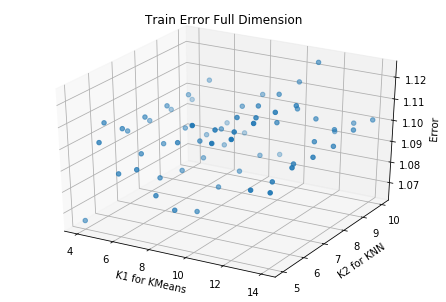

In [150]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(k1l, k2l, errl)
ax.set_xlabel("K1 for KMeans")
ax.set_ylabel("K2 for KNN")
ax.set_zlabel("Error")
plt.title('Train Error Full Dimension')
plt.show()

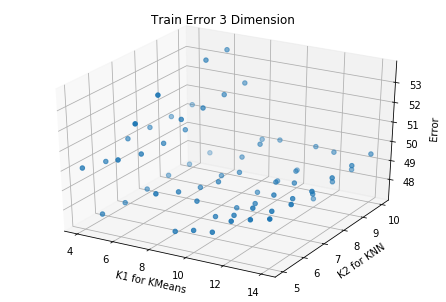

In [149]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(k1l, k2l, err_3dl)
ax.set_xlabel("K1 for KMeans")
ax.set_ylabel("K2 for KNN")
ax.set_zlabel("Error")
plt.title('Train Error 3 Dimension')
plt.show()

The validation error (3D distance).

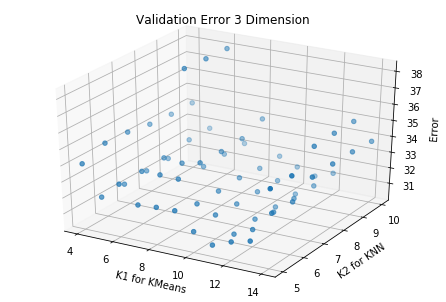

In [148]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(k1lv, k2lv, err_3dlv)
ax.set_xlabel("K1 for KMeans")
ax.set_ylabel("K2 for KNN")
ax.set_zlabel("Error")
plt.title('Validation Error 3 Dimension')
plt.show()

From which we can find the best values for K Means and KNN, which are 12 and 9 for training set and 11 and 6 for validaiton set. Hence we choose 12 and 8 for K Means and KNN.

In [90]:
print(errl.index(min(errl)),err_3dl.index(min(err_3dl)))

0 52


In [91]:
print(k1l[52],k2l[52])

12 9


In [84]:
print(errlv.index(min(errlv)),err_3dlv.index(min(err_3dlv)))

23 43


In [92]:
print(k1lv[43],k2lv[43])

11 6


Do the procedures again with parameters 12 and 8, and get the result.

In [93]:
kmeans = KMeans(n_clusters=12, n_init=30, n_jobs=-1)
user_3d_train1['label'] = kmeans.fit_predict(user_3d_train1)
user_3d_train1.head()

0          1         2  label
user_id                                       
1         7.897883  -2.026327  2.927302      9
2        25.860290  -8.534366  2.339784      8
3        -5.174689   3.188420 -2.295045      0
4         7.313143  -0.567869 -0.602519      6
5         5.213700 -11.094972 -1.075992      6

In [94]:
print('Cluster Label\tNumber of Users in Cluster')
for idx, val in (pd.get_dummies(user_3d_train1['label'])).sum().iteritems():
    print(str(idx)+'\t\t'+str(val))

Cluster Label	Number of Users in Cluster
0		752
1		366
2		432
3		490
4		474
5		732
6		536
7		277
8		383
9		520
10		461
11		577


In [96]:
model = KNeighborsClassifier(n_neighbors=8,p=2)
model = model.fit(user_3d_train1[[0,1,2]],user_3d_train1["label"])

In [97]:
label1 = pd.DataFrame(model.predict(user_3d_train1[[0,1,2]]))
label2 = pd.DataFrame(model.predict(user_3d_train2[[0,1,2]]))
label3 = pd.DataFrame(model.predict(user_3d_validation[[0,1,2]]))
label4 = pd.DataFrame(model.predict(user_3d_test[[0,1,2]]))
label1.index = user_3d_train1.index
label2.index = user_3d_train2.index
label3.index = user_3d_validation.index
label4.index = user_3d_test.index

In [98]:
user_rating_cluster = rating.join(user_3d_train1[['label']], on='user_id')
user_rating_cluster.loc[user_rating_cluster['rating'] == -1, 'rating'] = 5
user_rating_cluster.dropna(axis=0,inplace=True) #train1
user_rating_cluster.head()

user_id  anime_id  rating  label
0        1        20       5    9.0
1        1        24       5    9.0
2        1        79       5    9.0
3        1       226       5    9.0
4        1       241       5    9.0

In [99]:
clusters = (user_rating_cluster[['anime_id', 'rating', 'label']].groupby(by=['label', 'anime_id']).rating.agg(['mean', 'count']))
clusters["evaluation"] = clusters['mean'] * clusters['count']
clusters.head()

mean  count  evaluation
label anime_id                             
0.0   1         8.800766    261      2297.0
      5         8.363636     88       736.0
      6         8.430657    137      1155.0
      7         7.882353     17       134.0
      15        7.937500     16       127.0

In [100]:
clusters_evaluation = clusters[['evaluation']].dropna()
clusters_evaluation.head()

evaluation
label anime_id            
0.0   1             2297.0
      5              736.0
      6             1155.0
      7              134.0
      15             127.0

In [101]:
cluster_label = clusters_evaluation.index.get_level_values(0).unique().tolist()
rec = []
for c in cluster_label:
    rec.append(clusters_evaluation.loc[c].sort_values(by='evaluation', ascending=False).reset_index())
rec = pd.concat(rec, axis=1)
rec_10 = pd.DataFrame(rec.head(10))[["anime_id"]]
l = []
t = 0
for i in rec_10.columns:
    l.append(t)
    t += 1
rec_10.columns = l
rec_10.head()

0        1        2       3        4        5        6        7   \
0   1535.0  11757.0  11757.0  1535.0   1535.0  11757.0   1535.0   1535.0   
1  16498.0    853.0  16498.0  1575.0  16498.0   1535.0  16498.0  16498.0   
2   1575.0  16498.0   4224.0  5114.0  11757.0  16498.0  11757.0   1575.0   
3   2904.0   6547.0    853.0  2904.0   5114.0   6547.0   6547.0   5114.0   
4   5114.0    120.0   6547.0    30.0     20.0  19815.0   1575.0   2904.0   

        8        9        10     11  
0  16498.0  11757.0   1535.0   1535  
1     20.0  16498.0  16498.0   1575  
2  11757.0   6547.0  11757.0   2904  
3   1535.0    853.0   6547.0   5114  
4   6547.0   4224.0  10620.0  16498

In [102]:
err = 0
err_3d = 0
dict_cl = dict()
for u in user_genre_rating_train2.index:
    arrayx = np.array(user_genre_rating_train2.loc[u])
    cl = int(label2.loc[u])
    
    if cl in dict_cl:
        arrayy = dict_cl[cl]
    else:
        arrayy = cluster_to_value(rec_10[cl],anime_genre_rating)
        dict_cl[cl] = arrayy
    
    err += error(arrayx,arrayy)
    
    arrayx_3d = np.array(user_3d_train2.loc[u])
    arrayy_3d = np.array(pca.transform([arrayy])[0])
    err_3d += error(arrayx_3d,arrayy_3d)
print(err,err_3d)

err = 0
err_3d = 0
dict_cl = dict()
for u in user_genre_rating_validation.index:
    arrayx = np.array(user_genre_rating_validation.loc[u])
    cl = int(label3.loc[u])

    if cl in dict_cl:
        arrayy = dict_cl[cl]
    else:
        arrayy = cluster_to_value(rec_10[cl],anime_genre_rating)
        dict_cl[cl] = arrayy
    err += error(arrayx,arrayy)
    
    arrayx_3d = np.array(user_3d_validation.loc[u])
    arrayy_3d = np.array(pca.transform([arrayy])[0])
    err_3d += error(arrayx_3d,arrayy_3d)
print(err,err_3d)

err = 0
err_3d = 0
dict_cl = dict()
for u in user_genre_rating_test.index:
    arrayx = np.array(user_genre_rating_test.loc[u])
    cl = int(label4.loc[u])

    if cl in dict_cl:
        arrayy = dict_cl[cl]
    else:
        arrayy = cluster_to_value(rec_10[cl],anime_genre_rating)
        dict_cl[cl] = arrayy
    err += error(arrayx,arrayy)
    
    arrayx_3d = np.array(user_3d_test.loc[u])
    arrayy_3d = np.array(pca.transform([arrayy])[0])
    err_3d += error(arrayx_3d,arrayy_3d)
print(err,err_3d)

1.0984805654554963 49.665405272088535
1.1141373731805329 32.6668520979861
1.3496062062202747 35.46880605976121


The users with corresponding clusters in the test set

In [129]:
label4.head()

0
user_id    
10001     2
10002     9
10003    10
10004     9
10005     5

The information of the clusters with recommended anime

In [105]:
rec_10.head(10)

0        1        2        3        4        5        6        7   \
0   1535.0  11757.0  11757.0   1535.0   1535.0  11757.0   1535.0   1535.0   
1  16498.0    853.0  16498.0   1575.0  16498.0   1535.0  16498.0  16498.0   
2   1575.0  16498.0   4224.0   5114.0  11757.0  16498.0  11757.0   1575.0   
3   2904.0   6547.0    853.0   2904.0   5114.0   6547.0   6547.0   5114.0   
4   5114.0    120.0   6547.0     30.0     20.0  19815.0   1575.0   2904.0   
5  11757.0  18507.0   7054.0   2001.0   1575.0   1575.0    121.0    121.0   
6    226.0   2167.0   1535.0    226.0    121.0  10620.0   4224.0     20.0   
7   9253.0   7054.0  10620.0    121.0    226.0   4224.0   5114.0  11757.0   
8    121.0     20.0  19815.0  16498.0    813.0   9919.0    199.0      1.0   
9     20.0   9919.0  20507.0   4224.0   2904.0   5114.0   9919.0     30.0   

        8        9        10     11  
0  16498.0  11757.0   1535.0   1535  
1     20.0  16498.0  16498.0   1575  
2  11757.0   6547.0  11757.0   2904  
3   1535.0    853.0   6547.0   5114  
4   6547.0   4224.0  10620.0  16498  
5   1575.0   2167.0   5114.0   2001  
6    813.0   1535.0    226.0   9253  
7  11771.0  10620.0   1575.0    121  
8    269.0   7054.0     20.0   6547  
9   3457.0    199.0   8074.0   4224

Input the 10001st user, and get the anime recommendation for him/her.

In [147]:
user_id = 10001
cluster_num = label4.loc[user_id,0]
for i,id_ in rec_10[int(cluster_num)].items():
    anime_id = id_
    get = anime.loc[anime["anime_id"] == anime_id]
    print(int(anime_id),get["name"].values[0])

11757 Sword Art Online
16498 Shingeki no Kyojin
4224 Toradora!
853 Ouran Koukou Host Club
6547 Angel Beats!
7054 Kaichou wa Maid-sama!
1535 Death Note
10620 Mirai Nikki (TV)
19815 No Game No Life
20507 Noragami
